# Eğitim ve Veri Analizi Not Defteri
Bu not defteri `output/` ve `models/` altındaki çıktı dosyalarını inceleyerek: veri keşfi (EDA), eğitim loglarının görselleştirilmesi ve örnek çıkarım adımlarını içerir.

Not: Hücreler, dosyalar yoksa hatasız çalışacak şekilde kontroller ve `try/except` blokları içerir.

In [9]:
# Cell: imports and output paths
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set(style='whitegrid')

# Default output dir used by the training script (adjust if you used a different OUTPUT_DIR)
OUT_DIR = Path('outputs') / 'multitask-lora-fast'
metrics_csv = OUT_DIR / 'metrics.csv'
eval_jsonl = OUT_DIR / 'eval_predictions.jsonl'
test_metrics_txt = OUT_DIR / 'test_metrics.txt'

print('OUT_DIR =', OUT_DIR)
print('metrics.csv exists?', metrics_csv.exists())
print('eval_predictions.jsonl exists?', eval_jsonl.exists())
print('test_metrics.txt exists?', test_metrics_txt.exists())

# List available files in output dir (helpful quick check)
if OUT_DIR.exists():
    files = sorted(OUT_DIR.glob('*'))
    print(f"Found {len(files)} items in {OUT_DIR}:")
    for p in files:
        try:
            size = p.stat().st_size
        except Exception:
            size = 0
        print(f" - {p.name}\t{size:,} bytes")
else:
    print('Output directory does not exist yet.')


ModuleNotFoundError: No module named 'seaborn'

In [10]:
# Cell: Load metrics.csv if available
metrics_df = None
if metrics_csv.exists():
    try:
        metrics_df = pd.read_csv(metrics_csv)
        # Normalize column names if older/newer naming used in training script
        metrics_df.columns = [c.strip() for c in metrics_df.columns]
        display(metrics_df.head())
        display(metrics_df.describe(include='all'))

        # Ensure numeric columns
        for col in ['train_loss','eval_loss','train_em','eval_em','train_token_f1','eval_token_f1','train_rougeL_f1','eval_rougeL_f1']:
            if col in metrics_df.columns:
                metrics_df[col] = pd.to_numeric(metrics_df[col], errors='coerce')
    except Exception as e:
        print('Failed to read metrics.csv:', e)
else:
    print('metrics.csv not found in', OUT_DIR)


NameError: name 'metrics_csv' is not defined

In [ ]:
# Helper function: generate and save metric plots (loss + optional metric plots)
# Call: plot_train_eval_metrics(metrics_csv, OUT_DIR, window=5)
def plot_train_eval_metrics(metrics_csv=metrics_csv, out_dir=OUT_DIR, window=5):
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np

    PLOT_DIR = out_dir / 'analysis_plots'
    PLOT_DIR.mkdir(parents=True, exist_ok=True)

    try:
        df = pd.read_csv(metrics_csv)
    except Exception as e:
        raise RuntimeError(f"Failed to read metrics CSV at {metrics_csv}: {e}")

    df.columns = [c.strip() for c in df.columns]
    steps = df['step'] if 'step' in df.columns else np.arange(len(df))
    saved = []

    # Loss plot
    if 'train_loss' in df.columns and 'eval_loss' in df.columns:
        train_smooth = df['train_loss'].rolling(window=window, min_periods=1).mean()
        eval_smooth = df['eval_loss'].rolling(window=window, min_periods=1).mean()
        plt.figure(figsize=(10,5))
        plt.plot(steps, df['train_loss'], color='C0', alpha=0.25, label='train_loss (raw)')
        plt.plot(steps, df['eval_loss'], color='C1', alpha=0.25, label='eval_loss (raw)')
        plt.plot(steps, train_smooth, color='C0', label=f'train_loss (smoothed w={window})')
        plt.plot(steps, eval_smooth, color='C1', label=f'eval_loss (smoothed w={window})')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Train vs Eval Loss')
        plt.legend()
        plt.grid(True)
        outp = PLOT_DIR / 'train_eval_loss.png'
        plt.tight_layout()
        plt.savefig(outp)
        plt.close()
        saved.append(str(outp))

    # Other metric plots (EM, token_f1, rougeL)
    metric_pairs = [
        ('train_em','eval_em','Exact Match (EM)'),
        ('train_token_f1','eval_token_f1','Token F1'),
        ('train_rougeL_f1','eval_rougeL_f1','RougeL F1'),
    ]
    for tcol, ecol, title in metric_pairs:
        if tcol in df.columns and ecol in df.columns:
            plt.figure(figsize=(10,3))
            plt.plot(steps, df[tcol], alpha=0.4, label=f'train_{title}')
            plt.plot(steps, df[ecol], alpha=0.6, label=f'eval_{title}')
            plt.xlabel('Step')
            plt.ylabel(title)
            plt.title(title + ' over steps')
            plt.legend()
            plt.tight_layout()
            fname = title.lower().replace(' ','_') + '.png'
            ppath = PLOT_DIR / fname
            plt.savefig(ppath)
            plt.close()
            saved.append(str(ppath))

    print('Saved plots:', saved)
    return saved

# Optionally regenerate plots immediately if you want uncomment the next line
# plot_train_eval_metrics(metrics_csv, OUT_DIR, window=5)


In [ ]:
# Cell: Plot training and validation curves if metrics available
if metrics_df is not None and not metrics_df.empty:
    df = metrics_df.copy()
    PLOT_DIR = OUT_DIR / 'analysis_plots'
    PLOT_DIR.mkdir(parents=True, exist_ok=True)

    # Steps vector
    steps = df['step'] if 'step' in df.columns else np.arange(len(df))

    # Loss plot (raw + smoothed)
    plt.figure(figsize=(10,4))
    if 'train_loss' in df.columns and 'eval_loss' in df.columns:
        window = 5
        train_smooth = df['train_loss'].rolling(window=window, min_periods=1).mean()
        eval_smooth = df['eval_loss'].rolling(window=window, min_periods=1).mean()
        plt.plot(steps, df['train_loss'], alpha=0.25, label='train_loss (raw)')
        plt.plot(steps, df['eval_loss'], alpha=0.25, label='eval_loss (raw)')
        plt.plot(steps, train_smooth, label=f'train_loss (smoothed w={window})')
        plt.plot(steps, eval_smooth, label=f'eval_loss (smoothed w={window})')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Train vs Eval Loss')
        plt.legend()
        plt.tight_layout()
        loss_path = PLOT_DIR / 'train_eval_loss.png'
        plt.savefig(loss_path)
        plt.show()
        print('Saved loss plot to', loss_path)
    else:
        print('train_loss or eval_loss not present in metrics_df; columns:', df.columns.tolist())

    # Metric plots if present
    metric_pairs = [
        ('train_em','eval_em','Exact Match (EM)'),
        ('train_token_f1','eval_token_f1','Token F1'),
        ('train_rougeL_f1','eval_rougeL_f1','RougeL F1'),
    ]
    for tcol, ecol, title in metric_pairs:
        if tcol in df.columns and ecol in df.columns:
            plt.figure(figsize=(10,3))
            plt.plot(steps, df[tcol], alpha=0.4, label=f'train_{title}')
            plt.plot(steps, df[ecol], alpha=0.6, label=f'eval_{title}')
            plt.xlabel('Step')
            plt.ylabel(title)
            plt.title(title + ' over steps')
            plt.legend()
            plt.tight_layout()
            fname = title.lower().replace(' ','_') + '.png'
            ppath = PLOT_DIR / fname
            plt.savefig(ppath)
            plt.show()
            print('Saved', ppath)

    # Final values summary
    last = df.iloc[-1]
    print('\nFinal step summary:')
    vals = {}
    for col in ['train_loss','eval_loss','train_em','eval_em','train_token_f1','eval_token_f1']:
        if col in last.index:
            vals[col] = last[col]
    print(vals)
else:
    print('No metrics dataframe to plot.')


Processed parquet bulundu: ../data/processed/summarization_data.parquet
 ../data/processed/summarization_data.parquet
summarization_data bulundu: True
qa_data bulundu: True
summarization_data bulundu: True
qa_data bulundu: True


,text,summary
0,"Tuğba Özerk, “Duymayan Kalmasın” programında, ...",Tuğba Özerk'ten Deniz Akkaya’ya 100 bin TL’lik...
1,"MHP Genel Başkanı Bahçeli, Manisa'nın Selendi ...",Bahçeli: Cepheleşme keskinleşirse MHP buna tep...
2,Rusya’nın Suriye’ye havadan müdahaleye başlama...,YPG ve ABD omuz omuza
3,Galatasaray’da forvet transferinde halen somut...,Neredesin forvet?
4,İspanya'nın Marca Gazetesi'nde yayımlanan deme...,Daum: Guiza mutsuz


Dtypes:
text       object
summary    object
dtype: object
         count  percent
text         0      0.0
summary      0      0.0


,context,question,answers
0,"Ankara, 21 Ağustos 2024 - Türkiye'nin başkenti...",Etkinliğe kaç uzman katıldı?,"{'text': ['200'], 'answer_start': [197]}"


Dtypes:
context     object
question    object
answers     object
dtype: object
          count  percent
context       0      0.0
question      0      0.0
answers       0      0.0


In [ ]:
# Cell: Load eval_predictions.jsonl and show sample errors (low EM or low token_f1)
preds = []
if eval_jsonl.exists():
    with open(eval_jsonl, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                obj = json.loads(line)
                preds.append(obj)
            except Exception:
                pass
    print(f'Loaded {len(preds)} eval predictions')
    if preds:
        dfp = pd.DataFrame(preds)
        # normalize
        if 'em' in dfp.columns:
            dfp['em'] = pd.to_numeric(dfp['em'], errors='coerce')
        if 'token_f1' in dfp.columns:
            dfp['token_f1'] = pd.to_numeric(dfp['token_f1'], errors='coerce')

        # token overlap measure (simple)
        def token_overlap(p, t):
            ps = set(str(p).lower().split())
            ts = set(str(t).lower().split())
            if not ts: return 0.0
            return len(ps & ts) / len(ts)

        dfp['tok_overlap'] = dfp.apply(lambda r: token_overlap(r.get('prediction',''), r.get('target','')), axis=1)
        display(dfp.head())

        # Worst by token_f1
        if 'token_f1' in dfp.columns:
            worst = dfp.nsmallest(10, 'token_f1')
            print('\nWorst 10 by token_f1:')
            display(worst[['source','target','prediction','em','token_f1','tok_overlap']])

        # Random incorrect examples
        if 'em' in dfp.columns:
            wrong = dfp[dfp['em'] == 0]
            if len(wrong) > 0:
                sample_wrong = wrong.sample(min(10, len(wrong)), random_state=42)
                print('\nRandom sample of incorrect predictions (EM==0):')
                display(sample_wrong[['source','target','prediction','em','token_f1','tok_overlap']])

        # Distribution summaries
        print('\nToken F1 distribution:')
        if 'token_f1' in dfp.columns:
            display(dfp['token_f1'].describe())
        print('\nToken overlap distribution:')
        display(dfp['tok_overlap'].describe())
else:
    print('eval_predictions.jsonl not found in', OUT_DIR)


Loading tokenized datasets from ../data/tokenized
Train rows: 249457 Val rows: 27718
Train rows: 249457 Val rows: 27718
Using 100 validation examples for evaluation
Generating with batch_size=16 num_beams=1 (save every 10 batches)
Using 100 validation examples for evaluation
Generating with batch_size=16 num_beams=1 (save every 10 batches)


gen: 100%|██████████| 7/7 [00:48<00:00,  6.92s/it]



Saved predictions to ../output/eval_predictions.csv
ROUGE: {'rouge1': 0.004532537016299614, 'rouge2': 0.0014857881136950905, 'rougeL': 0.003829787234042554, 'rougeLsum': 0.003605823068309071}
Saved eval_metrics.json
Built eval dataframe with 100 rows
ROUGE: {'rouge1': 0.004532537016299614, 'rouge2': 0.0014857881136950905, 'rougeL': 0.003829787234042554, 'rougeLsum': 0.003605823068309071}
Saved eval_metrics.json
Built eval dataframe with 100 rows


Looking for: ../output/train_metrics.json ../output/eval_metrics.json ../output/eval_predictions.csv
Train metrics loaded
Eval metrics loaded
Eval predictions loaded with 100 rows


### Training summary

,training_loss,metrics,global_step
0,5.313008,"{'train_runtime': 64.6262, 'train_samples_per_...",64


### Evaluation metrics

,rouge1,rouge2,rougeL,rougeLsum
0,0.004533,0.001486,0.00383,0.003606


### Sample predictions (first 10)

,input,reference,prediction
0,Milyonlarca Apple kullancsnn talebi olan 4 inç...,iPhone 5S'in satş durduruldu,NaN
1,Geçen yla göre yüzde 10-20 orannda satşlarn ar...,Konut almak için geç kalmayn!,NaN
2,on zamanlarda Müslümanlar üzerindeki şiddetin ...,Dünyann gözünü yumduu vahşet: Arakan,NaN
3,"Vietnam'da erkek bebek doumlarnn hzla artt, ge...",Vietnam'da erkek doumlar alarm veriyor,NaN
4,"Beyaz Saray Sözcüsü Sarah Sanders, konuya iliş...","Trump, Irakl mahkumu öldüren ABD askerini affetti",NaN
5,haberi! Ahmet Edip Uur'un istifasyla boşalan '...,Balkesir'de yeni belediye başkan belli oldu (Z...,NaN
6,ili'nin başkenti Santiago film gibi bir soygun...,ili'de kolay soygun,NaN
7,"Alsancak Volkan Alabaş, Fatih Söyler, Gökmen B...",Derbi Altay'n,NaN
8,"Antalya'da bir kz çocuu, çukurda ölü bulundu. ...",Kayp çocuk çukurda ölü bulundu,NaN
9,Eski polis müdürlerinin sanklar arasnda olduu ...,Yasadş dinleme davasnda 20 tahliye,NaN


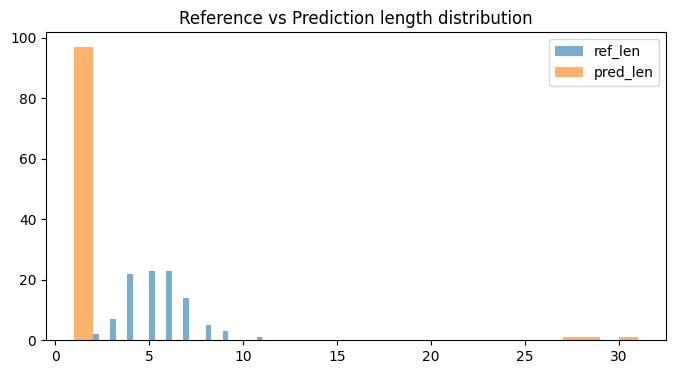

### Worst 10 examples (by token overlap proxy)

,input,reference,prediction,token_overlap
0,Milyonlarca Apple kullancsnn talebi olan 4 inç...,iPhone 5S'in satş durduruldu,NaN,0.0
71,"Arsenal'in Türk asll Alman yldz Mesut zil, ste...","Arsenal taraftar, Mesut zil’i yalanclkla suçluyor",NaN,0.0
70,Meteoroloji Genel Müdürlüünden alnan tahminler...,Meteoroloji uyard! Bu saatlere dikkat,NaN,0.0
69,Marmara Erelisi lçesi'nin Dereaz Mahallesi'nde...,Denizde kalp krizi geçiren eski rektör hayatn ...,NaN,0.0
68,14. kez düzenlenen ’nin “En iyi Filmini” bu yl...,"""ocuk Filmleri Festivali"" başlyor",NaN,0.0
67,"inhua ajansnn haberinde, Luşan kasabasndaki Ka...",in'de huzurevinde yangn: 38 ölü,NaN,0.0
66,Habertürk'ten Serdar Kulaksz'n haberine göre; ...,Son dakika: Dink cinayeti davasnda tahliye karar!,NaN,0.0
65,Fethullahç Terör rgütü soruşturmasnda önemli b...,Eski HSYK 1. Daire Başkan brahim Okur itirafç ...,NaN,0.0
64,Siyasi partilere ittifak imkan veren düzenleme...,AKP vekili Destici'ye Bahçeli'den BBP mesaj: 1...,NaN,0.0
63,stanbul’da konuşan Ekonomi Bakan Nihat Zeybekc...,Nihat Zeybekci: Büyüme ilk çeyrekte negatif ge...,NaN,0.0


In [ ]:
# Cell: Read test_metrics.txt (if produced) and show contents
if test_metrics_txt.exists():
    print('Contents of', test_metrics_txt)
    print('-'*40)
    print(test_metrics_txt.read_text(encoding='utf-8'))
else:
    print('No test_metrics.txt found in', OUT_DIR)

# Recommendations based on observed training outputs
print('\nQuick recommendations based on observed artifacts:')
if metrics_df is not None and not metrics_df.empty:
    last = metrics_df.iloc[-1]
    tr = last.get('train_loss', None)
    ev = last.get('eval_loss', None)
    if tr is not None and ev is not None and ev > tr * 1.2:
        print('- Validation loss significantly higher than training loss → possible overfitting. Try lower LR or stronger regularization.')
    if 'eval_token_f1' in last.index and last['eval_token_f1'] < 0.3:
        print('- Low eval token_f1 (<0.3) — consider increasing MAX_SOURCE_LEN or improving data quality.')
print('- To regenerate plots run the plotting cells; plots are saved under:', OUT_DIR / 'analysis_plots')


In [11]:
# Cell: Dedicated Train vs Eval Loss plot (raw + smoothed)
import matplotlib.pyplot as plt
import numpy as np

# Ensure metrics_df is loaded or try to load
if 'metrics_df' not in globals() or metrics_df is None:
    if metrics_csv.exists():
        try:
            metrics_df = pd.read_csv(metrics_csv)
        except Exception as e:
            raise RuntimeError(f"Failed to load metrics.csv: {e}")
    else:
        raise FileNotFoundError(f"metrics.csv not found at {metrics_csv}")

df = metrics_df.copy()
if 'train_loss' not in df.columns or 'eval_loss' not in df.columns:
    print('Columns available in metrics.csv:', df.columns.tolist())
    raise RuntimeError('train_loss and/or eval_loss not present in metrics.csv')

steps = df['step'] if 'step' in df.columns else np.arange(len(df))
window = 5  # smoothing window (adjust if needed)
train_smooth = df['train_loss'].rolling(window=window, min_periods=1).mean()
eval_smooth = df['eval_loss'].rolling(window=window, min_periods=1).mean()

plt.figure(figsize=(10,5))
plt.plot(steps, df['train_loss'], color='C0', alpha=0.25, label='train_loss (raw)')
plt.plot(steps, df['eval_loss'], color='C1', alpha=0.25, label='eval_loss (raw)')
plt.plot(steps, train_smooth, color='C0', label=f'train_loss (smoothed w={window})')
plt.plot(steps, eval_smooth, color='C1', label=f'eval_loss (smoothed w={window})')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Train vs Eval Loss')
plt.legend()
plt.grid(True)

PLOT_DIR = OUT_DIR / 'analysis_plots'
PLOT_DIR.mkdir(parents=True, exist_ok=True)
outp = PLOT_DIR / 'train_eval_loss.png'
plt.tight_layout()
plt.savefig(outp)
plt.show()
print('Saved plot to', outp)


NameError: name 'metrics_csv' is not defined

In [ ]:
# Cell: Display saved plots from analysis_plots (so you can quickly view them inline)
from IPython.display import Image, display
PLOT_DIR = OUT_DIR / 'analysis_plots'

if not PLOT_DIR.exists():
    print('No plots found at', PLOT_DIR)
else:
    imgs = sorted(PLOT_DIR.glob('*.png'))
    if not imgs:
        print('No PNG files found in', PLOT_DIR)
    for p in imgs:
        print('\n==', p.name, '==')
        try:
            display(Image(str(p)))
        except Exception as e:
            print('Failed to display', p, e)
